#Introduction:
Deep Learning: Deep learning is a subset of machine learning that focuses on using neural networks with many layers to model and solve complex problems. It involves algorithms inspired by the structure and function of the brain, specifically artificial neural networks, and is designed to automatically learn hierarchical patterns from large amounts of data.

Multivariate regression: Multivariate regression is a statistical technique used to model the relationship between multiple dependent variables (also called response or output variables) and one or more independent variables (predictors or input variables). In contrast to simple or multiple regression, which typically deals with one dependent variable, multivariate regression handles more than one dependent variable simultaneously.

In this project, we used neural network which is a series of transformations using multiple hidden layers and Leaky Relu and Relu as nonlinear activation functions to capture non-linear relationships between the RNA and ADT samples.
Use of Large language model is commendable to generate codes, and understand basic concepts.


#Approach
Use of a deep learning to solve multivariate problem: Deep learning offers significant advantages for solving multivariate such as automatically learn features, handle non-linear relationships, scale effectively, and integrate diverse data types.

K-fold cross validation and Hyperparamenter Tuning :

 We split our training data( RNA and ADT) into 80-20 train-test split and trained our model with 80% training data which we later on used to test with 20% of remaining data. we calculated our loss by comparing the actual and predicted ADT(protein) from 20% test split. Finally, the model performance is compared and the model with maximum accuracy is used to predict protein from the actual test RNA.

 Dropout reguralization is used with Leaky relu as an activation function which is initialized by He. Layer and Batch normalizations are used for faster training and convergence.

 The layer sizes of 512, 256, 128 are used so that the network can learn in a more compact abstract features. In this senario, both RNA and ADT data has numerous features, so using larger hidden layers can help the model capture complex interactions between those features before narrowing down the output size.




#Result
Overall result: The model's performance has been measured using Mean Squared Error (MSE), and predictions have been generated after training. Results for each fold, including test losses and model parameters, have been stored and averaged to assess the model's overall performance across folds.


Cross-validation:
Comparison of different layers(network architecture), activation function, batch size, learning rate, normalization technique, Optimizer, and dropout rate  is done to find out the least loss function/ error across various epoch of data.

The default neural net architecture is 3 layers with 512, 256, 128 neurons. The default batch size is 32 with learning rate 0.0001. The default normalization type is layer norm, and default dropout rate is 0.2. The default optimizer class is Adam. We have used Leaky ReLU as default activation function.

Figures:


   


#Conclusion

This approach is best to solve regression problems as it embraces non-linear relationship and doesnot require dimensionality reduction as with normal regression model.
Training the model is time consuming. There may be the risk of overfitting due to too complex architecture which may lead to poor generalization. Finding the optimal value with various hypoerparameters is challenging and time consuming.

By increasing the size of the data and effective data cleaning we can improve the model accuracy.

Future work: Stay updated and exploratin of new Machine learning techniques.






#Introduction:
Importing necessary libraries

In [ ]:
import os
from datetime import datetime
from collections import defaultdict, OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.nn import MSELoss

from sklearn.model_selection import KFold

Loading hte datasets

In [ ]:
training_set_rna = pd.read_csv('training_set_rna.csv', index_col=0, header=0)
training_set_adt = pd.read_csv('training_set_adt.csv', index_col=0, header=0)
test_set_rna = pd.read_csv('test_set_rna.csv', index_col=0, header=0)

#Approach
Initially, the k-fold crossvalidation is being performed by spliting training RNA and ADT data into a number of folds.

 Each fold contains training and test data for RNA and ADT. The splits are shuffled and can be controlled by setting the random_state for reproducibility. The function returns fold_splits, which is a list of tuples, with each tuple representing one fold (with training and testing data for both RNA and ADT).

In [ ]:
# K-fold

def create_kfold_splits(rna_data, adt_data, n_splits=5, shuffle=True, random_state=42):

    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    fold_splits = []

    for train_idx, test_idx in kf.split(range(rna_data.shape[1])):
        train_rna = rna_data[:, train_idx]
        test_rna = rna_data[:, test_idx]

        train_adt = adt_data[:, train_idx]
        test_adt = adt_data[:, test_idx]

        fold_splits.append((train_rna, test_rna, train_adt, test_adt))

    return fold_splits

Accessing the specific fold

In [ ]:
# k should be between 0 and 4 for 5-fold cross validation.
def get_kth_fold(X, Y,k=0):
    # Create dummy data
    rna_data = X.to_numpy()
    adt_data = Y.to_numpy()

    # Get fold splits
    folds = create_kfold_splits(rna_data, adt_data)

    # Print shapes for kth fold
    train_rna, test_rna, train_adt, test_adt = folds[k]

    return folds[k]

###**Creating Multivariate regression model**

Here, two classes are defined: RNADataset, which is a custom PyTorch Dataset for handling RNA and ADT data, and MultiVariateRegression, which is a neural network model designed for multivariate regression using RNA data to predict ADT values.





MultiVariateRegression: A feedforward neural network is created with several hidden layers (1024 -> 512 -> 256 neurons), ReLU activations, and dropout regularization. It takes RNA data as input and predicts ADT values (protein expressions).




The RNADataset Class is a custom dataset designed to facilitate the efficient batch loading of RNA and ADT data using PyTorch’s DataLoader. Complementing this, the MultiVariateRegression Class serves as a configurable feedforward neural network specifically tailored for multivariate regression tasks.

This architecture offers flexibility with customizable hidden layers, normalization methods, dropout rates, and activation functions. Notably, He initialization is employed to enhance weight initialization, particularly beneficial when utilizing LeakyReLU activation.

During the forward pass, the data traverses multiple hidden layers, where normalization, activation, and dropout are systematically applied before reaching the final linear layer for output. This robust architecture is well-suited for regression tasks, where the input comprises gene expression data (RNA) and the output represents corresponding protein expression data (ADT).

Droupout: Dropout is used to randomly set 30% of the neurons to zero during training, which helps prevent overfitting by making the network less sensitive to the specific weights of individual neurons.

Activation function: Leaky Relu, Relu

Reguralization: Dropout

Normalization:Batch, Layer

Layers: 512, 256, 128

Initialization: He


In [ ]:
class RNADataset(Dataset):
    def __init__(self, rna_data, adt_data):
        self.rna_data = torch.FloatTensor(rna_data.T)
        self.adt_data = torch.FloatTensor(adt_data.T)

    def __len__(self):
        return len(self.rna_data)

    def __getitem__(self, idx):
        return self.rna_data[idx], self.adt_data[idx]

class MultiVariateRegression(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=[512, 256, 128],
                 dropout_rate=0.25, normalization_type='layer', activation=nn.LeakyReLU, nonlinearity='leaky_relu'):
        """
        Enhanced MultiVariate Regression model with flexible architecture.

        Args:
            input_size: Number of input features
            output_size: Number of output features
            hidden_sizes: List of hidden layer sizes
            dropout_rate: Dropout probability (0 to 1)
            normalization_type: 'batch' or 'layer' for respective normalization
            activation: Activation function class (default: nn.LeakyReLU)
        """
        super(MultiVariateRegression, self).__init__()

        # Input validation : Making sure that hidden_sizes is not empty and the dropout_rate is between 0 and 1.
        if not hidden_sizes:
            raise ValueError("hidden_sizes list cannot be empty")
        if not 0 <= dropout_rate <= 1:
            raise ValueError("dropout_rate must be between 0 and 1")
        #Creating a list that consisit of all size layers, starting with input, hidden and output sizes
        self.normalization_type = normalization_type
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        # Create layers dynamically rendering flexibility
        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.nonlinearity = nonlinearity

        # Creating the network architecture
        for i in range(len(layer_sizes) - 1):
            # Add linear layer
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))

            # Adding normalization for all except the last layer. Normalization helps in faster training and convergence.
            if i < len(layer_sizes) - 2:
                if normalization_type == 'batch':
                    self.norms.append(nn.BatchNorm1d(layer_sizes[i + 1]))
                elif normalization_type == 'layer':
                    self.norms.append(nn.LayerNorm(layer_sizes[i + 1]))
                else:
                    raise ValueError("normalization_type must be either 'batch' or 'layer'")

        # Activation and dropout
        self.activation = activation()
        self.dropout = nn.Dropout(dropout_rate)

        # Initializing weights using He initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity=self.nonlinearity)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, x):
        """Forward pass through the network."""
        for i, (layer, norm) in enumerate(zip(self.layers[:-1], self.norms)):
            x = layer(x)
            x = norm(x)
            x = self.activation(x)
            x = self.dropout(x)

        # Output layer (no normalization or activation)
        x = self.layers[-1](x)
        return x

    def get_num_parameters(self):
        """Return the number of trainable parameters."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


#Result

A k-fold cross-validation process has been implemented for training and evaluating a multivariate regression model. Different configurations of the model, including batch size, learning rate, number of epochs, dropout rate, and hidden layers, have been tested. The model has been initialized with specific activation functions and optimizers, such as ReLU and Adam, based on user inputs. The RNA and ADT datasets have been split into training and testing sets for each fold. The model's performance has been measured using Mean Squared Error (MSE), and predictions have been generated after training. Results for each fold, including test losses and model parameters, have been stored and averaged to assess the model's overall performance across folds.

In [ ]:
results = {}

def train_and_evaluate_kfold(X, Y, n_splits=5, batch_size=32,
                           learning_rate=0.0001, num_epochs=100,
                           dropout_rate=0.2, hidden_layer=[512,256,128],
                           normalization_type="layer", opt_name="Adam", activation_name='relu'):


    fold_results = []

    optimizers = {
            'Adam': torch.optim.Adam,
            'SGD': torch.optim.SGD
    }

    activation_functions = {
        'relu': nn.ReLU,
        'leaky_relu': nn.LeakyReLU
    }



    experiment_name = f'arch_{hidden_layer}_activation_name_{activation_name}_batch_{batch_size}_opt_name_{opt_name}_lr_{learning_rate}_dr_{dropout_rate}_norm_{normalization_type}_epoch_{num_epochs}'

    optimizer_class = optimizers[opt_name]
    activation = activation_functions[activation_name]
    nonlinearity = activation_name

    for fold in range(n_splits):
        # Get data for this fold
        train_rna, test_rna, train_adt, test_adt = get_kth_fold(X, Y, k=fold)

        print(f"\nTraining model with experiment: {experiment_name}")
        print(f"Fold: {fold+1}/{n_splits}")
        print("-" * 50)

        # Initialize dataset and dataloader
        dataset = RNADataset(train_rna, train_adt)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # Initialize model
        input_size = train_rna.shape[0]
        output_size = train_adt.shape[0]

        # model = MultiVariateRegression(input_size, output_size)
        model = MultiVariateRegression(
            input_size,
            output_size,
            hidden_layer,
            dropout_rate,
            normalization_type,
            activation,
            nonlinearity
        )


        optimizer = optimizer_class(model.parameters(), lr=learning_rate)
        criterion = MSELoss()

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0

            for batch_rna, batch_adt in dataloader:
                outputs = model(batch_rna)
                loss = criterion(outputs, batch_adt)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()



            avg_loss = total_loss / len(dataloader)

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

        # Evaluation phase
        model.eval()
        with torch.no_grad():
            test_tensor = torch.FloatTensor(test_rna.T)
            predictions = model(test_tensor)
            test_loss = criterion(predictions, torch.FloatTensor(test_adt.T))
            predictions = predictions.numpy().T

        # Store fold results
        fold_results.append({
            'model': model,
            'predictions': predictions,
            'test_loss': test_loss.item()
        })



    # Calculate and log average performance across folds
    avg_test_loss = np.mean([fold['test_loss'] for fold in fold_results])
    std_test_loss = np.std([fold['test_loss'] for fold in fold_results])

    # Store results for this batch size
    results[experiment_name] = {
        'fold_results': fold_results,
        'avg_test_loss': avg_test_loss,
        'std_test_loss': std_test_loss
    }

    print(f"\nExperiment results:")
    print(f"Average test loss: {avg_test_loss:.4f} ± {std_test_loss:.4f}")

    # return results


**Cross validation and Hyperparameter Tuning**

Overall, this line initiates the training and evaluation process for the model, and the results of the k-fold cross-validation will be stored in the results variable, which will include metrics like average test loss and performance details across the folds.

A series of neural network experiments were conducted using different combinations of hyperparameters. The configurations explored included hidden layer structures, batch sizes, learning rates, dropout rates, normalization methods, numbers of training epochs, optimizers, and activation functions. Specifically, hidden layer sizes of [512, 256, 128] were tested, along with a batch size of 32, a learning rate of 0.001, dropout rates of 0.2, 0.3, and 0.4, and the "layer" normalization type. The Adam optimizer and LeakyReLU activation function were used for a total of 150 epochs. These experiments were evaluated using 5-fold cross-validation on the RNA and ADT training sets, and the results were recorded for each configuration.

In [ ]:
results = {}

hidden_layer_configs = [
        [512, 256, 128]
] # the other options are: [1024, 512, 256], [256, 128, 64], [512, 256, 128, 64]

batch_sizes = [32] # 64,128,256

learning_rates = [0.001] # the other values: 0.0001, 0.01

dropout_rates = [0.2] # 0.5, 0.1, 0.3, 0.4

normalization_types = ['layer'] # 'batch' is another option

nums_epochs = [150] # Try other values like 50, 100, 120

optimizer_classes = ['Adam'] # 'SGD' is another option

activation_functions = ['leaky_relu'] # other option is 'relu'


for hidden_layer in hidden_layer_configs:
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            for dropout_rate in dropout_rates:
                for normalization_type in normalization_types:
                    for num_epochs in nums_epochs:
                        for opt_name in optimizer_classes:
                            for activation_name in activation_functions:
                                train_and_evaluate_kfold(training_set_rna, training_set_adt,
                                                         5, batch_size, learning_rate, num_epochs,
                                                         dropout_rate, hidden_layer, normalization_type,
                                                         opt_name, activation_name)

Below is the results of the k-fold cross-validation, where the data is prepared as a tensor, which makes predictions using two models trained with different batch sizes, and prints the shape of the predictions array.
The final output will indicate how many predicted ADT values correspond to the test RNA samples. The approach ensures to easily evaluate different model setups and utilize the best-performing one for making predictions on new data.


In [ ]:
def select_top_10_models(results):
    # Sort experiments by average test loss
    sorted_experiments = sorted(results.items(),
                                key=lambda x: x[1]['avg_test_loss'])

    top_10_models = OrderedDict(sorted_experiments[:10])

    print("\nTop 10 Model Configurations:")
    for i, (experiment_name, model_dict) in enumerate(top_10_models.items(), 1):
        print(f"\n{i}. Experiment name: {experiment_name}")
        print(f"   Average Test Loss: {model_dict['avg_test_loss']:.4f} ± {model_dict['std_test_loss']:.4f}")

        print("   Performance across folds:")
        for j, fold_result in enumerate(model_dict['fold_results']):
            print(f"   Fold {j+1} Test Loss: {fold_result['test_loss']:.4f}")

    return top_10_models


In [ ]:

def make_predictions(model, new_data):
    model.eval()
    with torch.no_grad():
        new_data_tensor = torch.FloatTensor(new_data.T)
        predictions = model(new_data_tensor)
        return predictions.numpy().T



**Creating the submission file**

In [ ]:
def create_submission_file(array_2d, experiment_name):
    assert array_2d.shape == (25, 1000), "Input array must have shape (25, 1000)"

    id_column = [f'ID_{i+1}' for i in range(25000)]

    expected_column = array_2d.flatten('F')

    # Create DataFrame
    df = pd.DataFrame({
        'Id': id_column,
        'Expected': expected_column
    })

    df.to_csv(f'{experiment_name}.csv', index=False)

    print(f"Submission file for {experiment_name} has been created successfully!")
    return df



**Top Ten Models**

In [ ]:
def process_top_10_models(results, new_rna_data):
    top_10_models = select_top_10_models(results)

    for experiment_name, model_dict in top_10_models.items():
        # Select the best fold model for each experiment
        best_fold_idx = min(range(len(model_dict['fold_results'])),
                            key=lambda i: model_dict['fold_results'][i]['test_loss'])
        best_model = model_dict['fold_results'][best_fold_idx]['model']

        # Make predictions
        predictions = make_predictions(best_model, new_rna_data)

        # Create submission file
        create_submission_file(predictions, experiment_name)


In [ ]:
process_top_10_models(results, test_set_rna.values)


**Visualizations**

The following code generates images for comparing loss vs epoch for different neural network hidden layer number, hidden layer size, normalization type, learning rate, dropout rate, batch sizes, optimizer classes. The images are presented at the presentation.

In [ ]:
class ExperimentManager:
    def __init__(self, X, Y, base_log_dir="runs/RNA_ADT_experiments",
                 n_splits=5, num_epochs=100):
        self.X = X
        self.Y = Y
        self.base_log_dir = base_log_dir
        self.n_splits = n_splits
        self.num_epochs = num_epochs
        self.timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')

    def run_batch_size_experiment(self, batch_sizes=[32, 64, 128, 256]):
        """Run experiments with different batch sizes"""
        experiment_name = f'batch_size_comparison_{self.timestamp}'
        writer = SummaryWriter(os.path.join(self.base_log_dir, experiment_name))
        results = defaultdict(list)

        for batch_size in batch_sizes:
            losses = self._run_k_fold(batch_size=batch_size,
                                    experiment_name=f'batch_{batch_size}')

            # Average losses across folds for each epoch
            avg_losses = np.mean(losses, axis=0)
            std_losses = np.std(losses, axis=0)

            # Log to tensorboard
            for epoch, (avg_loss, std_loss) in enumerate(zip(avg_losses, std_losses)):
                writer.add_scalar(f'Loss/batch_size_{batch_size}', avg_loss, epoch)
                results[batch_size].append(avg_loss)

        self._plot_comparison(results, 'Batch Size Comparison', 'batch_size_comparison.png',
                            xlabel='Epochs', ylabel='Loss', legend_prefix='Batch Size ')
        writer.close()

    def run_normalization_experiment(self):
        """Compare layer normalization vs batch normalization"""
        experiment_name = f'normalization_comparison_{self.timestamp}'
        writer = SummaryWriter(os.path.join(self.base_log_dir, experiment_name))
        results = defaultdict(list)

        for norm_type in ['layer', 'batch']:
            losses = self._run_k_fold(normalization_type=norm_type,
                                    experiment_name=f'norm_{norm_type}')

            avg_losses = np.mean(losses, axis=0)
            for epoch, avg_loss in enumerate(avg_losses):
                writer.add_scalar(f'Loss/{norm_type}_norm', avg_loss, epoch)
                results[norm_type].append(avg_loss)

        self._plot_comparison(results, 'Normalization Comparison', 'normalization_comparison.png',
                            xlabel='Epochs', ylabel='Loss')
        writer.close()

    def run_optimizer_experiment(self):
        """Compare Adam vs SGD optimizer"""
        experiment_name = f'optimizer_comparison_{self.timestamp}'
        writer = SummaryWriter(os.path.join(self.base_log_dir, experiment_name))
        results = defaultdict(list)

        optimizers = {
            'Adam': torch.optim.Adam,
            'SGD': torch.optim.SGD
        }

        for opt_name, opt_class in optimizers.items():
            losses = self._run_k_fold(optimizer_class=opt_class,
                                    experiment_name=f'opt_{opt_name}')

            avg_losses = np.mean(losses, axis=0)
            for epoch, avg_loss in enumerate(avg_losses):
                writer.add_scalar(f'Loss/{opt_name}', avg_loss, epoch)
                results[opt_name].append(avg_loss)

        self._plot_comparison(results, 'Optimizer Comparison', 'optimizer_comparison.png',
                            xlabel='Epochs', ylabel='Loss')
        writer.close()

    def run_learning_rate_experiment(self, learning_rates=[0.0001, 0.001, 0.01]):
        """Compare different learning rates"""
        experiment_name = f'learning_rate_comparison_{self.timestamp}'
        writer = SummaryWriter(os.path.join(self.base_log_dir, experiment_name))
        results = defaultdict(list)

        for lr in learning_rates:
            losses = self._run_k_fold(learning_rate=lr,
                                    experiment_name=f'lr_{lr}')

            avg_losses = np.mean(losses, axis=0)
            for epoch, avg_loss in enumerate(avg_losses):
                writer.add_scalar(f'Loss/lr_{lr}', avg_loss, epoch)
                results[lr].append(avg_loss)

        self._plot_comparison(results, 'Learning Rate Comparison', 'learning_rate_comparison.png',
                            xlabel='Epochs', ylabel='Loss', legend_prefix='LR ')
        writer.close()

    def run_dropout_rate_experiment(self, dropout_rates=[0, 0.2, 0.3, 0.4, 0.5]):
        """Compare different learning rates"""
        experiment_name = f'dropout_rate_comparison_{self.timestamp}'
        writer = SummaryWriter(os.path.join(self.base_log_dir, experiment_name))
        results = defaultdict(list)

        for dr in dropout_rates:
            losses = self._run_k_fold(dropout_rate=dr,
                                    experiment_name=f'dr_{dr}')

            avg_losses = np.mean(losses, axis=0)
            for epoch, avg_loss in enumerate(avg_losses):
                writer.add_scalar(f'Loss/dr_{dr}', avg_loss, epoch)
                results[dr].append(avg_loss)

        self._plot_comparison(results, 'Dropout Rate Comparison', 'dropout_rate_comparison.png',
                            xlabel='Epochs', ylabel='Loss', legend_prefix='DR ')
        writer.close()

    def run_architecture_search(self, hidden_layer_configs):
        """
        Run experiments with different hidden layer configurations

        Args:
            hidden_layer_configs: List of lists specifying different architectures
                                e.g., [[512, 256], [256, 128, 64], ...]
        """
        experiment_name = f'architecture_comparison_{self.timestamp}'
        writer = SummaryWriter(os.path.join(self.base_log_dir, experiment_name))
        results = defaultdict(list)

        for config in hidden_layer_configs:
            config_name = '_'.join(map(str, config))
            losses = self._run_k_fold(hidden_sizes=config,
                                    experiment_name=f'arch_{config_name}')

            avg_losses = np.mean(losses, axis=0)
            for epoch, avg_loss in enumerate(avg_losses):
                writer.add_scalar(f'Loss/arch_{config_name}', avg_loss, epoch)
                results[tuple(config)].append(avg_loss)

        self._plot_comparison(results, 'Architecture Comparison', 'architecture_comparison.png',
                            xlabel='Epochs', ylabel='Loss', legend_prefix='Layers ')
        writer.close()

    def _run_k_fold(self, **kwargs):
        """Run k-fold cross validation with given parameters"""
        kf = KFold(n_splits=self.n_splits, shuffle=True)
        fold_losses = []

        rna_data = self.X.to_numpy()
        adt_data = self.Y.to_numpy()

        for fold, (train_idx, test_idx) in enumerate(kf.split(range(rna_data.shape[1]))):
            train_rna = rna_data[:, train_idx]
            test_rna = rna_data[:, test_idx]
            train_adt = adt_data[:, train_idx]
            test_adt = adt_data[:, test_idx]

            train_losses = self._train_fold(train_rna, test_rna, train_adt, test_adt, fold, **kwargs)
            fold_losses.append(train_losses)


        return np.array(fold_losses)

    def _train_fold(self, train_rna, test_rna, train_adt, test_adt, fold, **kwargs):
        """Train a single fold and return losses"""
        # Initialize model, optimizer, criterion here
        # Train the model and collect losses
        # Return list of losses for each epoch

        batch_size = kwargs.get('batch_size', 32)
        learning_rate = kwargs.get('learning_rate', 0.0001)
        normalization_type = kwargs.get('normalization_type', 'layer')
        optimizer_class = kwargs.get('optimizer_class', torch.optim.Adam)
        hidden_sizes = kwargs.get('hidden_sizes', [512, 256, 128])
        dropout_rate = kwargs.get('dropout_rate', 0.2)
        experiment_name = kwargs.get('experiment_name', 'default')

        dataset = RNADataset(train_rna, train_adt)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        input_size = train_rna.shape[0]
        output_size = train_adt.shape[0]


        model = MultiVariateRegression(input_size, output_size, hidden_sizes, dropout_rate, normalization_type)
        optimizer = optimizer_class(model.parameters(), lr=learning_rate)
        criterion = MSELoss()

        global_step = 0
        epoch_loss = []

        print("-" * 50)

        print(f'Experiment name: {experiment_name}:')
        for epoch in range(self.num_epochs):
            model.train()
            total_loss = 0

            for batch_rna, batch_adt in dataloader:
                outputs = model(batch_rna)
                loss = criterion(outputs, batch_adt)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

                global_step += 1

            avg_loss = total_loss / len(dataloader)

            epoch_loss.append(avg_loss)

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {avg_loss:.4f}')

        return epoch_loss

    def _plot_comparison(self, results, title, filename, xlabel='Epochs', ylabel='Loss',
                        legend_prefix=''):
        """Create and save comparison plots"""
        plt.figure(figsize=(10, 10))
        for key, values in results.items():
            label = f'{legend_prefix}{key}'
            plt.plot(values, label=label)

        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(self.base_log_dir, filename))
        plt.close()

# Example usage:
def run_experiments(X, Y):
    experiment_manager = ExperimentManager(X, Y)

    # Run batch size comparison
    experiment_manager.run_batch_size_experiment(batch_sizes=[32, 64, 128, 256])

    # Run normalization comparison
    experiment_manager.run_normalization_experiment()

    # Run optimizer comparison
    experiment_manager.run_optimizer_experiment()

    # Run learning rate comparison
    experiment_manager.run_learning_rate_experiment(learning_rates=[0.0001, 0.001, 0.01])

    # Run dropout rate comparison
    experiment_manager.run_dropout_rate_experiment()

    # Run architecture search
    hidden_layer_configs = [
        [512, 256, 128],
        [1024, 512, 256],
        [256, 128, 64],
        [512, 256, 128, 64]
    ]
    experiment_manager.run_architecture_search(hidden_layer_configs)

In [ ]:
run_experiments(training_set_rna, training_set_adt)

The generated graphs are presented below. The default neural net architecture is 3 layers with 512, 256, 128 neurons. The default batch size is 32 with learning rate 0.0001. The default normalization type is layer norm, and default dropout rate is 0.2. The default optimizer class is Adam. We have used Leaky ReLU as default activation function.

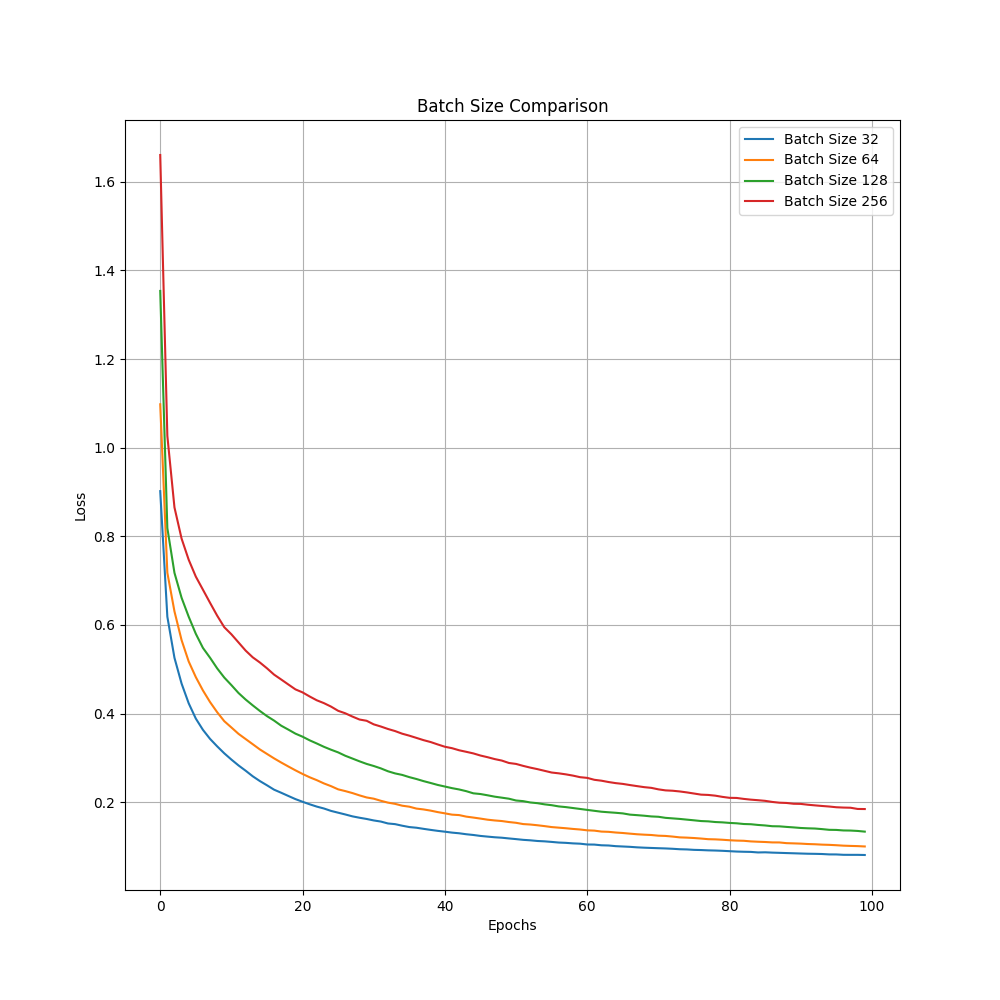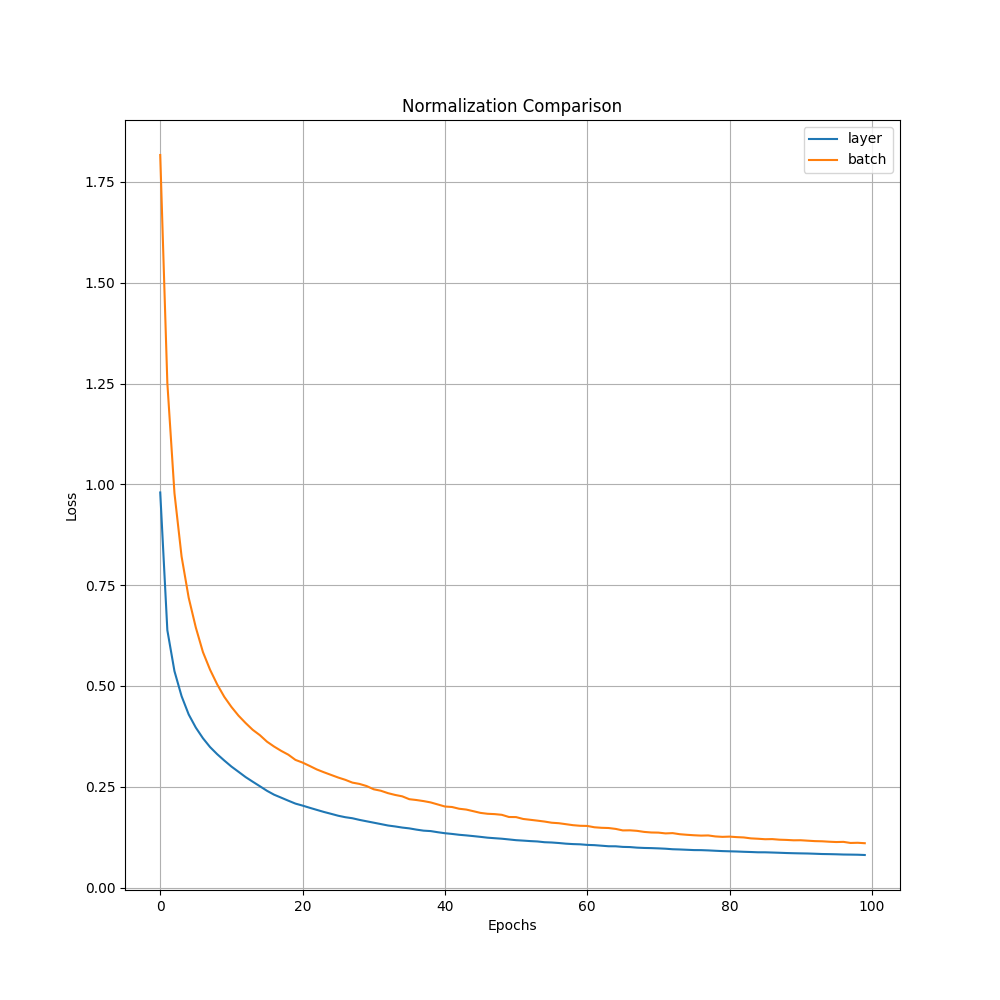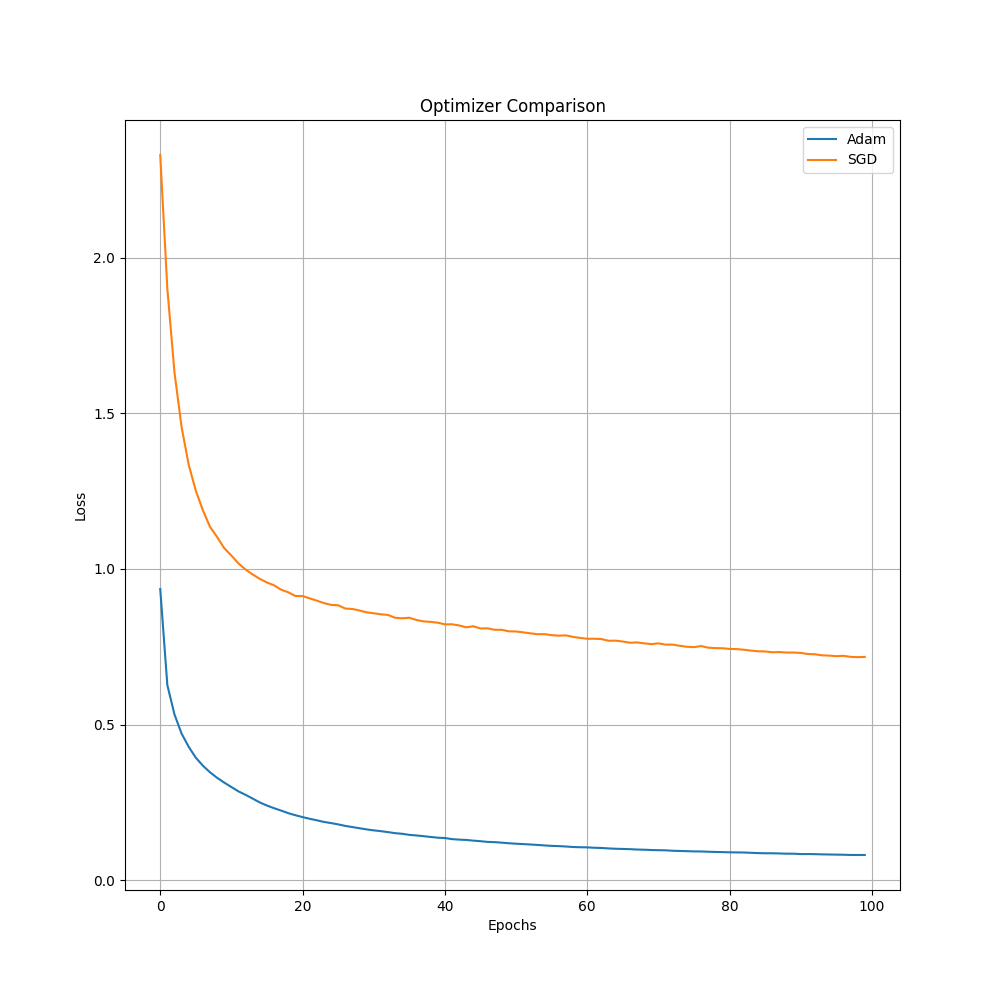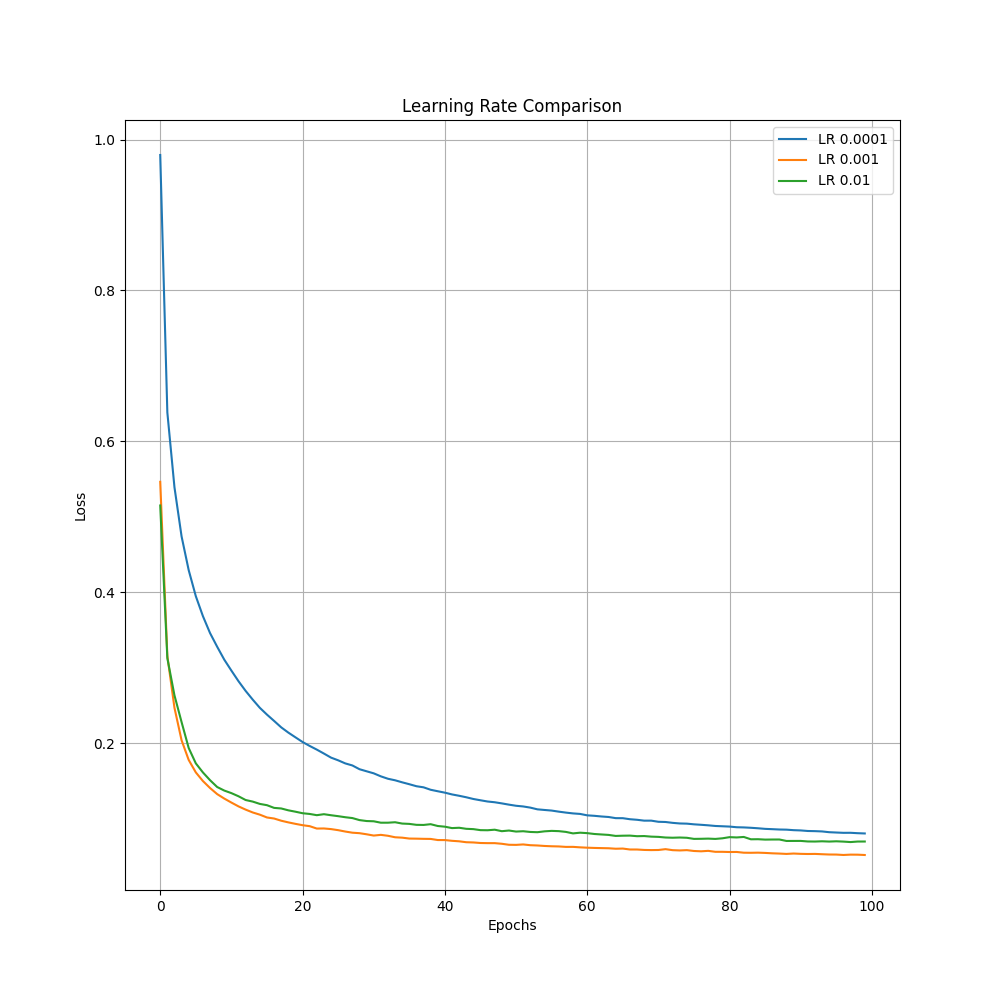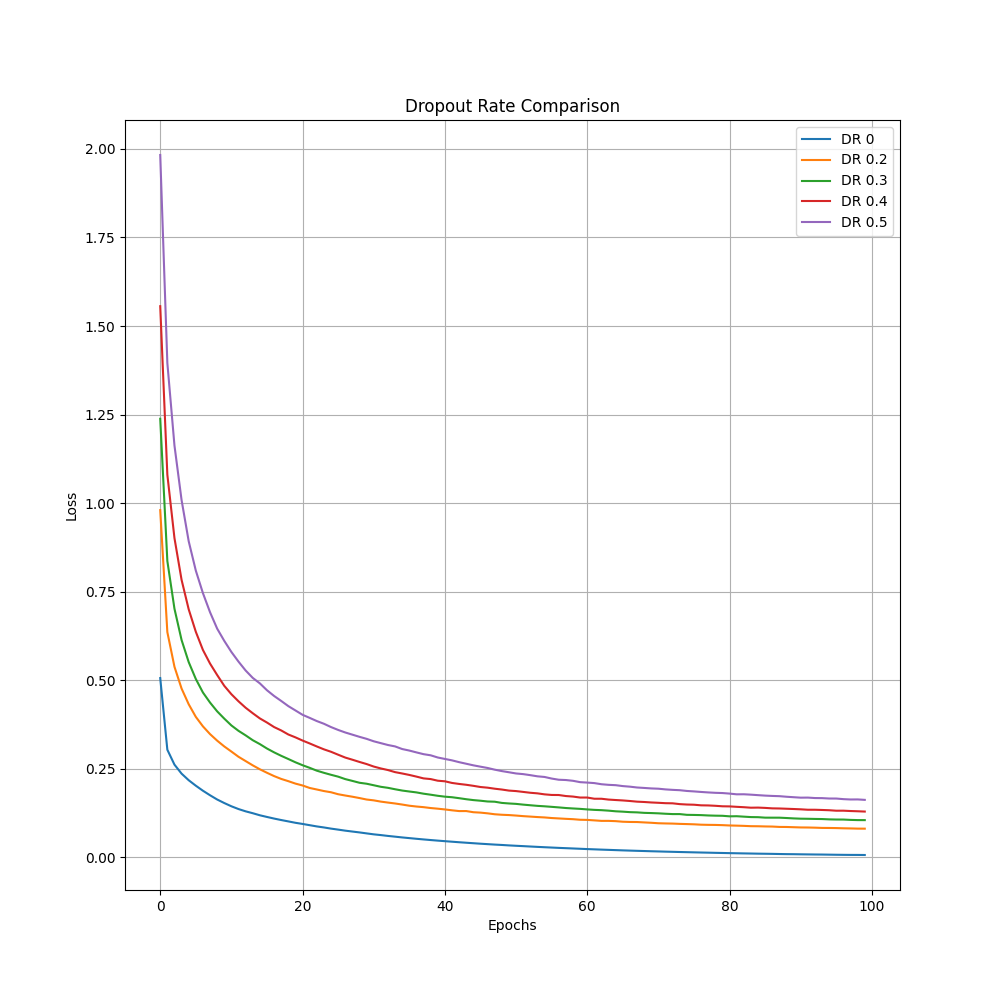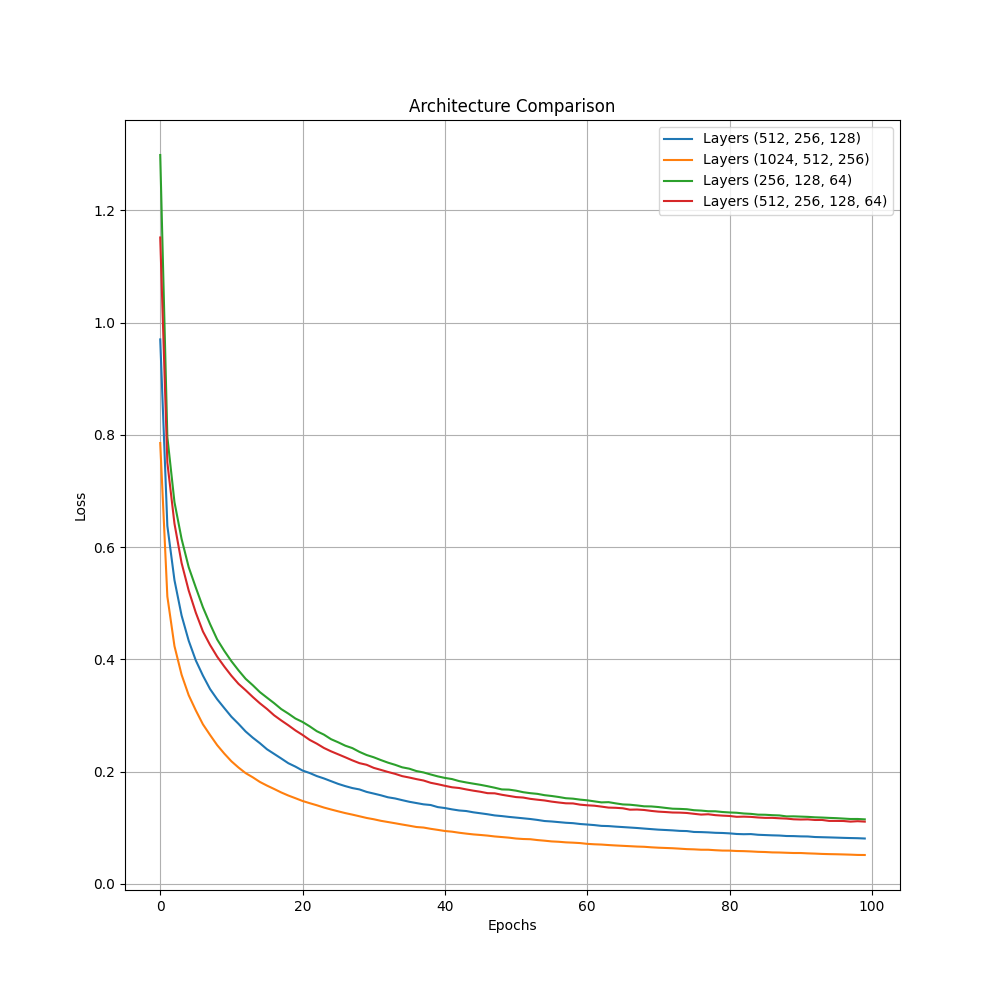

#Conclusion:

This approach is best to solve regression problems as it embraces non-linear relationship and does not require dimensionality reduction as with normal regression model. However, training the model is time consuming. There may be the risk of overfitting due to too complex architecture which may lead to poor generalization. Finding the optimal value with various hyperparameters is the real challenge in deep learning problems.

Future work: Stay updated and exploration of new machine learning techniques.